# Inference of parameters with latent variables (SEIR model)
In this notebook, we consider the SEIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{E}$ (rate from exposed to infected)
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 


when partially observed data ($I_s$ only) from a generated trajectory.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [3]:
M  = 2              # the population has two age groups
N  = 1e6            # and this is the total population

# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives
fsa   = 0.8         # the self-isolation parameter (assumed to be known)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([0, 0])  # each age group has exposed individuals,
Ia0 = np.array([1, 0])  # and asymptomatic infectives,
Is0 = np.array([5, 0])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 200
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau-leaping')
data_array = data['X']
np.save('latent_SEIR_traj.npy', data_array)

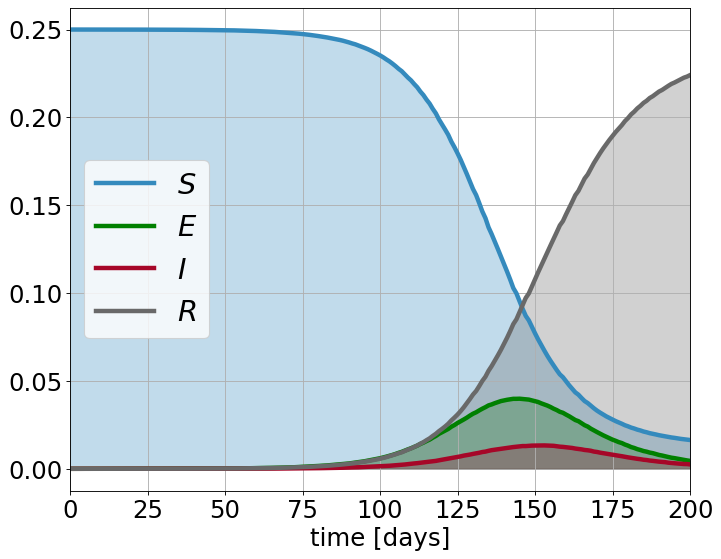

In [4]:
# plot the data and obtain the epidemic curve for one age group 
S  = data_array[:,0]
E  = data_array[:,2]
Ia = data_array[:,4]
Is = data_array[:,6]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

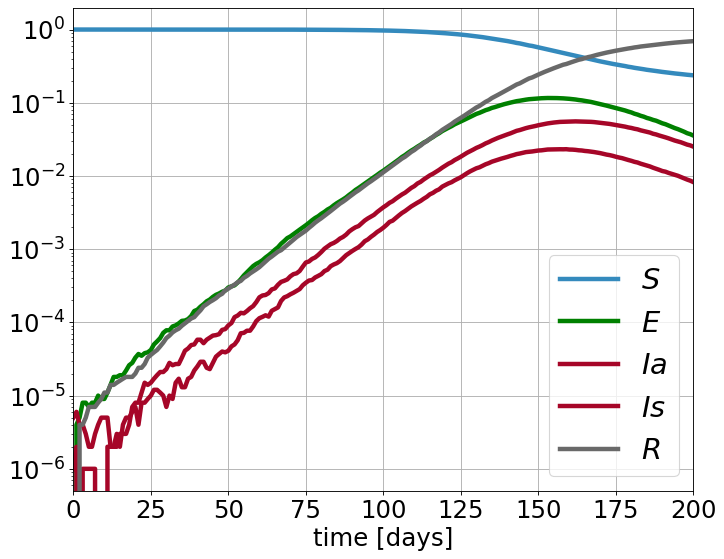

In [5]:
# plot the data and obtain the epidemic curve for one age group 
S  = np.sum(data_array[:,0:M], axis=1)
E  = np.sum(data_array[:,M:2*M], axis=1)
Ia = np.sum(data_array[:,2*M:3*M], axis=1)
Is = np.sum(data_array[:,3*M:4*M], axis=1)
R=N-S-Ia-Is-E
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.semilogy(t, S/N, '-', color="#348ABD", label='$S$', lw=4)
plt.semilogy(t, E/N, '-', color="green", label='$E$', lw=4)
plt.semilogy(t, Ia/N, '-', color='#A60628', label='$Ia$', lw=4)
plt.semilogy(t, Is/N, '-', color='#A60628', label='$Is$', lw=4)
plt.semilogy(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## 2) Inference
We take the first $60$ data points of the $I_\mathrm{s}$ trajectory and use it to infer the parameters of the model.

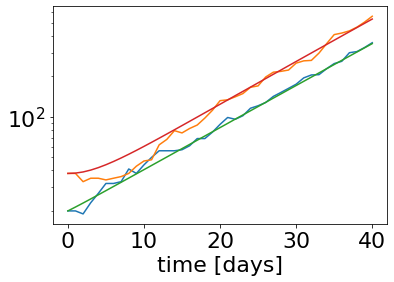

In [29]:
# load the data and rescale to intensive variables 
N_start = 40
Tf_inference = 40 # can truncate later 
Nf_inference = Tf_inference + 1

A = 1

x = np.load('latent_SEIR_traj.npy').astype('float')
x = x[N_start:N_start+Nf_inference]/A
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, Ni/A, A, steps)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
det_model = estimator.make_det_model(parameters)


time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference, det_model, contactMatrix)

plt.semilogy(obs[:, -2:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm)[:, -2:])
plt.xlabel("time [days]")
plt.show()


2.363017


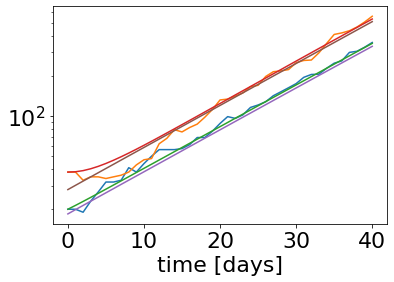

In [30]:
# test the approximation of the initial conditions by v 
zero_state = np.zeros((4*M))
zero_state[:M] = Ni 
dev = x0 - zero_state 

_ = estimator.lin_mode_inits(1, contactMatrix)

from scipy import sparse
J = estimator.J_mat[M:, M:]
eigval = sparse.linalg.eigs(J, k=1, which='LR')
eigval = np.real(eigval[0])
Jp = J - eigval*np.identity(J.shape[0])
res = pyross.contactMatrix.characterise_transient(Jp, ord=1)
K = np.real(res[2])
print(K)

c = np.linalg.norm(dev, ord=1)*1
v = estimator.lin_mode_inits(c, contactMatrix)


xm_approx = estimator.integrate(v, 0, Tf_inference, Nf_inference, det_model, contactMatrix)

plt.semilogy(obs[:, -2:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm)[:, -2:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm_approx)[:, -2:])
plt.xlabel("time [days]")
plt.show()

In [31]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa,'gIs':gIs, 'gE':gE, 'fsa':fsa}

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

495.0983655377965
0.040081024169921875


In [32]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3

beta_g = 0.02
beta_std = 0.1
beta_bounds = (eps, 1)

gIa_g = 0.14
gIa_std = 0.02 
gIa_bounds = (eps, 1)

gIs_g = 0.14
gIs_std = 0.05
gIs_bounds = (eps, 1) 

gE_g = 0.1
gE_std = 0.04 
gE_bounds = (eps, 0.2) 

coeff_g = c
coeff_std = coeff_g*5 
coeff_b = (eps, coeff_g*100)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
bounds = np.array([beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, 
                   coeff_b])
guess = np.array([beta_g, gIa_g, gIs_g, gE_g, coeff_g])
stds = np.array([beta_std, gIa_std, gIs_std, gE_std, coeff_std])
param_keys = ['beta', 'gIa', 'gIs', 'gE']
start_time = time.time()
estimator.set_lyapunov_method('euler')
params = estimator.latent_infer_parameters_lin_mode_init(param_keys, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    tangent=True,
                                    cma_population=32,
                                    global_max_iter=200, global_atol=1, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 5 (seed=296859033, Wed Jun 17 20:09:26 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     32 1.128156356598169e+03 1.0e+00 1.03e+00  2e-02  3e+03 0:00.4
    2     64 7.739919726201006e+02 1.3e+00 1.10e+00  2e-02  3e+03 0:00.8
    3     96 1.957749681894700e+03 1.5e+00 9.51e-01  2e-02  2e+03 0:01.2
   12    384 6.571859354209807e+02 2.9e+00 8.86e-01  2e-02  1e+03 0:04.3
   25    800 6.776782995457024e+02 6.1e+00 1.38e+00  2e-02  3e+03 0:08.5
   41   1312 5.390398401272038e+02 2.1e+01 8.72e-01  3e-03  8e+02 0:13.7
   60   1920 5.253944370751249e+02 6.0e+01 1.98e+00  4e-03  4e+02 0:19.8
   82   2624 5.185375995910738e+02 1.1e+02 5.65e+00  3e-03  1e+02 0:26.9
  100   3200 5.149983485974936e+02 1.9e+02 2.02e+01  3e-03  9e+01 0:32.6
  115   3680 5.139546828844336e+02 2.2e+02 2.53e+01  1e-03  2e+01 0:37.3
Optimal value (global minimisation):  513.8610796107848
Starting local 

In [33]:
# save the parameters 
np.save('SEIR_latent_param.npy', params)

In [34]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE,'fsa':fsa}
x0 = x[0]
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
print(parameters, logp)

print('\nTrue initial conditions: ') 
print((x0*A).astype('int'))
print('R initial = ', (Ni - A*np.sum(x0.reshape((4, M)), axis=0)))

params = np.load('SEIR_latent_param.npy')
best_estimates = estimator.fill_params_dict(param_keys, params)

coeff = params[-1]
print('\ncoeff for init', coeff)

x0 = estimator.lin_mode_inits(coeff, contactMatrix)
logp = estimator.minus_logp_red(best_estimates, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)

print('\nBest estimates')
print(best_estimates, logp)


print('\nInferred initial conditons: ') 
print((x0*A).astype('int'))
print('R initial = ', (Ni - A*np.sum(x0.reshape((4, M)), axis=0)))

True parameters
{'alpha': array([0.5, 0.2]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 0.8} 496.25449867135825

True initial conditions: 
[249801 749835     83     66     20      5     20     38]
R initial =  [76. 56.]

coeff for init 752.8656135633627

Best estimates
{'alpha': array([0.5, 0.2]), 'beta': 0.023405344462504456, 'gIa': 0.12146791518455453, 'gIs': 0.14444492223748504, 'gE': 0.06953845413905822, 'fsa': array([0.8, 0.8])} 664.9639380470337

Inferred initial conditons: 
[249761 749772    100     95     23      8     23     35]
R initial =  [91.72020823 87.23321238]


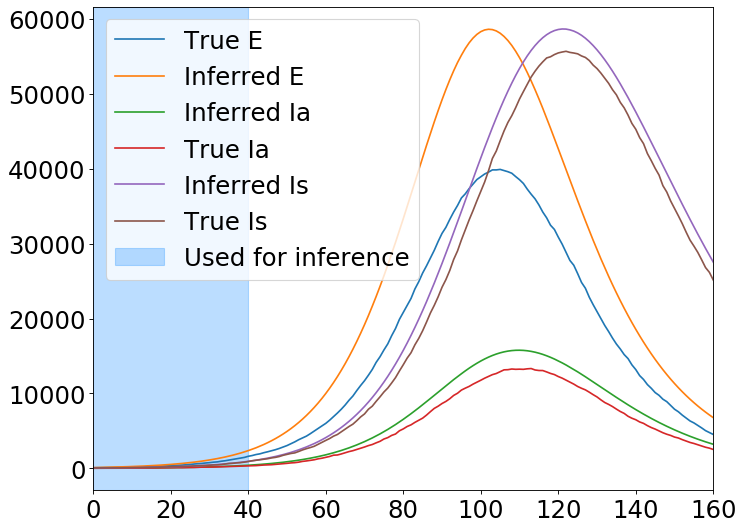

In [35]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
det_model = estimator.make_det_model(best_estimates)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(x0, 0, Tf-N_start, Nf-N_start, det_model, contactMatrix)
x = np.load('latent_SEIR_traj.npy').astype('float')[N_start:]/A
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,M], label='True E')
plt.plot(x_det[:, M], label='Inferred E')
plt.plot(x_det[:, 2*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Ia')
plt.plot(np.sum(x_det[:, 3*M:], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf-N_start])
plt.legend()
plt.show()